In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import re
import requests
from bs4 import BeautifulSoup as bs
import json
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

import acquire as ac
import prepare as pr
import wrangle as wr

# Acquiring Data:

In [2]:
shared_word_list = ['cat', 'use', 'image', 'using', 'file', 'run']
X_train, y_train, X_validate, y_validate, X_test, y_test, df, df_languages = wr.cat_wrangle(extra_words = (shared_word_list))

Removed 60 rows with empty Readmes.
Removed 197 rows with Readmes < 10 words long.
Train = 415 rows (56.0%) | Validate = 179 rows (24.0%) | Test = 149 rows (20.0%)


In [3]:
train, validate, test = wr.splitter(df)

Train = 415 rows (56.0%) | Validate = 179 rows (24.0%) | Test = 149 rows (20.0%)
You did not stratify.  If looking to stratify, ensure to add argument: "target = variable to stratify on".


In [4]:
train.head()

,language,cleaned,cleaned_length,language_group
35,Rust,migrated markdown mdcat showcase different col...,180,Other
59,Scala,steward client built top async java client qui...,121,Scala
923,Jupyter Notebook,classification dog wav project obtained corpus...,555,Other
282,Scala,clock 1000 millis allows rather update ref ref...,130,Scala
142,Python,hipsterize dog deep contains face detection pr...,107,Python


# Preparing Data:

## Cleaning the original DataFrame: 
- Creates rows for repo name, top language, the contents of the readme, and the cleaned text of the readmes:
    - Removes newlines, urls, and words that are longer than 14 characters.
    - Makes it all lowercase, tokenizes the words, and then lemmatizes (or stems) them.

#### Removing any records that are fewer than 11 words (leaves 743 records left):

# Exploration
- My focus is on bigrams and word visualizations.

In [5]:
train.language_group.value_counts()

Other         197
Scala          82
Python         74
JavaScript     62
Name: language_group, dtype: int64

## Creating WordClouds:

### Python:

#### Creating separate DataFrame of Python-lead READMEs:

In [6]:
python_df = train[train.language_group == 'Python']

In [7]:
python_df.head(2)

,language,cleaned,cleaned_length,language_group
142,Python,hipsterize dog deep contains face detection pr...,107,Python
619,Python,classification dog datasets datasets structure...,11,Python


#### Joining all the text from Python READMEs into a single group:

In [8]:
python_text = ''
for i in range(python_df.shape[0]):
    python_text = python_text + python_df.cleaned.iloc[i]
    
python_text[0:200]

'hipsterize dog deep contains face detection pretrained mobilenetv2 facial landmark detection pretrained mobilenetv2 first used frontal face detector look bad performance real photo decided make new mo'

#### Creating a WordCloud from all of the Python text:

(-0.5, 399.5, 199.5, -0.5)

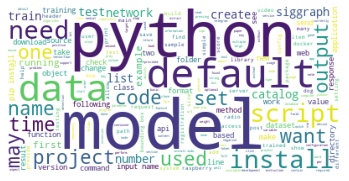

In [9]:
img = WordCloud(background_color='white').generate(python_text)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')

#### Creating bigrams from the text:

In [10]:
bigrams = nltk.ngrams(python_text.split(), 2)
list(bigrams)

[('hipsterize', 'dog'),
 ('dog', 'deep'),
 ('deep', 'contains'),
 ('contains', 'face'),
 ('face', 'detection'),
 ('detection', 'pretrained'),
 ('pretrained', 'mobilenetv2'),
 ('mobilenetv2', 'facial'),
 ('facial', 'landmark'),
 ('landmark', 'detection'),
 ('detection', 'pretrained'),
 ('pretrained', 'mobilenetv2'),
 ('mobilenetv2', 'first'),
 ('first', 'used'),
 ('used', 'frontal'),
 ('frontal', 'face'),
 ('face', 'detector'),
 ('detector', 'look'),
 ('look', 'bad'),
 ('bad', 'performance'),
 ('performance', 'real'),
 ('real', 'photo'),
 ('photo', 'decided'),
 ('decided', 'make'),
 ('make', 'new'),
 ('new', 'model'),
 ('model', 'deep'),
 ('deep', 'learning'),
 ('learning', 'method'),
 ('method', 'used'),
 ('used', 'face'),
 ('face', 'detection'),
 ('detection', 'landmark'),
 ('landmark', 'detection'),
 ('detection', 'model'),
 ('model', 'naive'),
 ('naive', 'real'),
 ('real', 'application'),
 ('application', 'work'),
 ('work', 'extremely'),
 ('extremely', 'well'),
 ('well', 'expected')

In [11]:
top_20_python_bigrams = (pd.Series(nltk.ngrams(python_text.split(), 2))
                      .value_counts()
                      .head(20))

top_20_python_bigrams.head()

(input, name)      32
(pip, install)     31
(bounding, box)    19
(install, sudo)    16
(sudo, pip)        14
dtype: int64

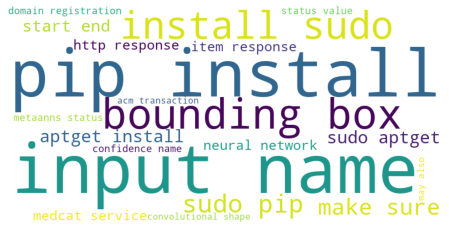

In [12]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_python_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

Given that these bigrams seem to be single letters, mostly nonsensical, it may be worth adding a condition to the cleaning function that eliminates words that are only single letters (although it's worth noting that this could eliminate things like "I" or "a."

### Scala:

In [13]:
scala_df = train[train.language_group == 'Scala']

In [14]:
scala_text = ''
for i in range(scala_df.shape[0]):
    scala_text = scala_text + scala_df.cleaned.iloc[i]
    
scala_text[0:200]

'steward client built top async java client quick quickstart extends ioappsimple def iounit redis ioprintlnx yield api quite stable heavily used production however binary compatibility guaranteed acros'

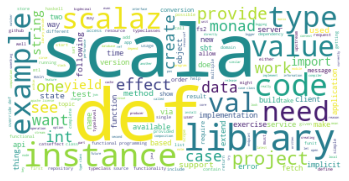

In [15]:
img = WordCloud(background_color='white').generate(scala_text)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off');

In [16]:
scala_bigrams = nltk.ngrams(scala_text.split(), 2)
list(scala_bigrams)

[('steward', 'client'),
 ('client', 'built'),
 ('built', 'top'),
 ('top', 'async'),
 ('async', 'java'),
 ('java', 'client'),
 ('client', 'quick'),
 ('quick', 'quickstart'),
 ('quickstart', 'extends'),
 ('extends', 'ioappsimple'),
 ('ioappsimple', 'def'),
 ('def', 'iounit'),
 ('iounit', 'redis'),
 ('redis', 'ioprintlnx'),
 ('ioprintlnx', 'yield'),
 ('yield', 'api'),
 ('api', 'quite'),
 ('quite', 'stable'),
 ('stable', 'heavily'),
 ('heavily', 'used'),
 ('used', 'production'),
 ('production', 'however'),
 ('however', 'binary'),
 ('binary', 'compatibility'),
 ('compatibility', 'guaranteed'),
 ('guaranteed', 'across'),
 ('across', 'version'),
 ('version', 'like'),
 ('like', 'give'),
 ('give', 'think'),
 ('think', 'could'),
 ('could', 'better'),
 ('better', 'please'),
 ('please', 'let'),
 ('let', '1xx'),
 ('1xx', 'series'),
 ('series', 'built'),
 ('built', 'effect'),
 ('effect', 'whereas'),
 ('whereas', '0xx'),
 ('0xx', 'series'),
 ('series', 'built'),
 ('built', 'effect'),
 ('effect', 'bui

In [17]:
top_20_scala_bigrams = (pd.Series(nltk.ngrams(scala_text.split(), 2))
                      .value_counts()
                      .head(20))

top_20_scala_bigrams.head()

(functional, programming)    24
(override, def)              19
(type, class)                18
(apache, license)            17
(case, class)                16
dtype: int64

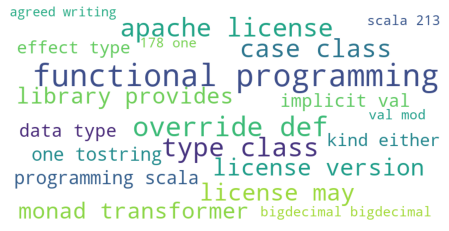

In [18]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_scala_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

## JavaScript:

In [19]:
js_df = train[train.language_group == 'JavaScript']

In [20]:
js_text = ''
for i in range(js_df.shape[0]):
    js_text = js_text + js_df.cleaned.iloc[i]
    
js_text[0:200]

'filterous instagramlike manipulation library javascript revamped version filterous written javascript browser year ago version work nodejs browser come predefined instagramlike filter filter name simi'

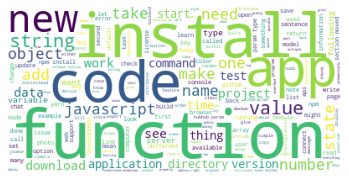

In [21]:
img = WordCloud(background_color='white').generate(js_text)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off');

In [22]:
js_bigrams = nltk.ngrams(js_text.split(), 2)
list(js_bigrams)

[('filterous', 'instagramlike'),
 ('instagramlike', 'manipulation'),
 ('manipulation', 'library'),
 ('library', 'javascript'),
 ('javascript', 'revamped'),
 ('revamped', 'version'),
 ('version', 'filterous'),
 ('filterous', 'written'),
 ('written', 'javascript'),
 ('javascript', 'browser'),
 ('browser', 'year'),
 ('year', 'ago'),
 ('ago', 'version'),
 ('version', 'work'),
 ('work', 'nodejs'),
 ('nodejs', 'browser'),
 ('browser', 'come'),
 ('come', 'predefined'),
 ('predefined', 'instagramlike'),
 ('instagramlike', 'filter'),
 ('filter', 'filter'),
 ('filter', 'name'),
 ('name', 'similar'),
 ('similar', 'module'),
 ('module', 'nodecanvas'),
 ('nodecanvas', 'need'),
 ('need', 'please'),
 ('please', 'follow'),
 ('follow', 'installation'),
 ('installation', 'guide'),
 ('guide', 'npm'),
 ('npm', 'install'),
 ('install', 'minified'),
 ('minified', 'javascript'),
 ('javascript', 'code'),
 ('code', 'available'),
 ('available', 'release'),
 ('release', 'usage'),
 ('usage', 'slightly'),
 ('sligh

In [23]:
top_20_js_bigrams = (pd.Series(nltk.ngrams(js_text.split(), 2))
                      .value_counts()
                      .head(20))

top_20_js_bigrams.head()

(npm, install)          26
(param, type)           18
(section, moved)        15
(hubhub, param)         14
(callback, function)    11
dtype: int64

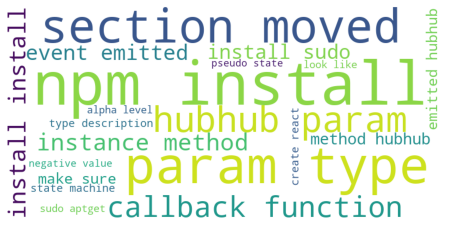

In [24]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_js_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

## Other:

In [25]:
other_df = train[train.language_group == 'Other']

In [26]:
other_text = ''
for i in range(other_df.shape[0]):
    other_text = other_text + other_df.cleaned.iloc[i]
    
other_text[0:200]

'migrated markdown mdcat showcase different colour kitty tango light solarized light dracula left pragmatapro work best iterm2 kitty good terminal font italic nicely render basic commonmark syntax tabl'

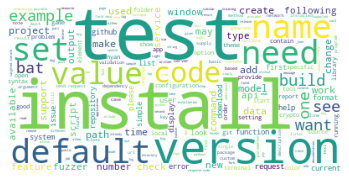

In [27]:
img = WordCloud(background_color='white').generate(other_text)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off');

In [28]:
other_bigrams = nltk.ngrams(other_text.split(), 2)
list(other_bigrams)

[('migrated', 'markdown'),
 ('markdown', 'mdcat'),
 ('mdcat', 'showcase'),
 ('showcase', 'different'),
 ('different', 'colour'),
 ('colour', 'kitty'),
 ('kitty', 'tango'),
 ('tango', 'light'),
 ('light', 'solarized'),
 ('solarized', 'light'),
 ('light', 'dracula'),
 ('dracula', 'left'),
 ('left', 'pragmatapro'),
 ('pragmatapro', 'work'),
 ('work', 'best'),
 ('best', 'iterm2'),
 ('iterm2', 'kitty'),
 ('kitty', 'good'),
 ('good', 'terminal'),
 ('terminal', 'font'),
 ('font', 'italic'),
 ('italic', 'nicely'),
 ('nicely', 'render'),
 ('render', 'basic'),
 ('basic', 'commonmark'),
 ('commonmark', 'syntax'),
 ('syntax', 'tablesgh2'),
 ('tablesgh2', 'highlight'),
 ('highlight', 'code'),
 ('code', 'block'),
 ('block', 'show'),
 ('show', 'linksosc8'),
 ('linksosc8', 'inline'),
 ('inline', 'supported'),
 ('supported', 'terminal'),
 ('terminal', 'see'),
 ('see', 'rust'),
 ('rust', 'clickable'),
 ('clickable', 'add'),
 ('add', 'jump'),
 ('jump', 'mark'),
 ('mark', 'heading'),
 ('heading', 'iterm2'

In [29]:
top_20_other_bigrams = (pd.Series(nltk.ngrams(other_text.split(), 2))
                      .value_counts()
                      .head(20))

top_20_other_bigrams.head()

(send, request)        39
(response, code)       32
(field, send)          30
(targeted, iterate)    27
(make, sure)           22
dtype: int64

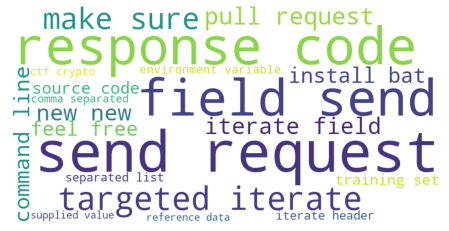

In [30]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_other_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

# Prepping for modeling:

## Establishing a Baseline:
- It appears that our baseline model, which would assign the most common language group to all of the repos, would have an accuracy of about 47%.

In [33]:
train.language_group.value_counts()

Other         197
Scala          82
Python         74
JavaScript     62
Name: language_group, dtype: int64

In [35]:
train[train.language_group == 'Other'].shape[0] / train.shape[0]

0.4746987951807229

## Creating three classification models to pick the best:

In [31]:
df.head()

,language,cleaned,cleaned_length,language_group
0,Scala,scala version continuous contributor open libr...,499,Scala
1,Python,nyaav2 build setting project python feature us...,462,Python
2,JavaScript,httpcat build website hosted code older versio...,79,JavaScript
3,Python,repository toy project gain experience buildin...,174,Python
4,Rust,cat1 clone syntax highlighting git feature ins...,1340,Other


### Logistic Regression:

In [32]:
X = tfidf.fit_transform(df.cleaned)
y = df.language_group

train_validate, X_test, y_train_validate, y_test = train_test_split(X, y, test_size=.2, stratify = y)
X_train, X_validate, y_train, y_validate = train_test_split(train_validate, y_train_validate, test_size=.2, stratify = y_train_validate)

train = pd.DataFrame(dict(actual=y_train))
validate = pd.DataFrame(dict(actual=y_validate))

lm = LogisticRegression().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
validate['predicted'] = lm.predict(X_validate)

NameError: name 'tfidf' is not defined

In [ ]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

In [ ]:
print('Accuracy: {:.2%}'.format(accuracy_score(validate.actual, validate.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(validate.predicted, validate.actual))
print('---')
print(classification_report(validate.actual, validate.predicted))

# <span style = 'color:green'>KNN: </span>

In [ ]:
y_validate.value_counts()

In [ ]:
X = tfidf.fit_transform(df.cleaned)
y = df.language_group

train_validate, X_test, y_train_validate, y_test = train_test_split(X, y, test_size=.2, stratify = y)
X_train, X_validate, y_train, y_validate = train_test_split(train_validate, y_train_validate, test_size=.2, stratify = y_train_validate)

train = pd.DataFrame(dict(actual=y_train))
validate = pd.DataFrame(dict(actual=y_validate))

knn = KNeighborsClassifier(n_neighbors = 19, weights='uniform')
knn.fit(X_train, y_train)

train['knn_predicted'] = knn.predict(X_train)
validate['knn_predicted'] = knn.predict(X_validate)

print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

In [ ]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_validate, y_validate)))

In [ ]:
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

# Decision Tree:

In [ ]:
X = tfidf.fit_transform(df.cleaned)
y = df.language_group

train_validate, X_test, y_train_validate, y_test = train_test_split(X, y, test_size=.2, stratify = y)
X_train, X_validate, y_train, y_validate = train_test_split(train_validate, y_train_validate, test_size=.2, stratify = y_train_validate)

train = pd.DataFrame(dict(actual=y_train))
validate = pd.DataFrame(dict(actual=y_validate))

clf = DecisionTreeClassifier(max_depth=17, random_state=123)
clf = clf.fit(X_train, y_train)

train['clf_predicted'] = clf.predict(X_train)
validate['clf_predicted'] = clf.predict(X_validate)

In [ ]:
#This Decision Tree shows an ~88 percent accuracy on the train set
print(classification_report(y_train, train.clf_predicted))

In [ ]:
print(classification_report(y_validate, validate.clf_predicted))